In [6]:
from a3_utils import *
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [7]:
def gauss(sigma):
    gauss_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (1 / (math.sqrt(2 * math.pi) * sigma)) * \
            math.exp(-((x ** 2) / (2 * (sigma ** 2))))
        gauss_kernel.append(result_x)
    return np.array(gauss_kernel) / sum(gauss_kernel)

def gaussdx(sigma):
    gaussdx_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (-1 / (math.sqrt(2 * math.pi) * sigma ** 3)) * x * math.exp(-(x ** 2 / (2 * sigma ** 2)))
        gaussdx_kernel.append(result_x)
    return np.array(gaussdx_kernel) / sum(np.abs(gaussdx_kernel))

def compute_derivative(img, sigma):
    G=gauss(sigma).reshape(1,-1)
    GT=G.T
    G=np.flip(G)
    GT=np.flip(GT)

    D=gaussdx(sigma).reshape(1,-1)
    DT=D.T
    D=np.flip(D)
    DT=np.flip(DT)

    img_Gt = cv2.filter2D(img, -1, D)
    deriv_x = cv2.filter2D(img_Gt, -1, GT)
    img_G = cv2.filter2D(img, -1, G)
    deriv_y = cv2.filter2D(img_G, -1, DT)
    return deriv_x, deriv_y

def gradient_magnitude(img, sigma):
    Ix,Iy=compute_derivative(img,sigma)

    M=np.sqrt(Ix**2+Iy**2)

    angle=np.arctan2(Iy,Ix)

    return M,angle

def findedges(I, sigma, theta):
    I_mag, angle = gradient_magnitude(I, sigma)
    binary_matrix = np.zeros(I_mag.shape)
    binary_matrix[I_mag >= theta] = 1
    return binary_matrix


def hysteresis(I, sigma, theta, tlow, thigh):
    I_mag,angle=gradient_magnitude(I,sigma)

    supressed = I_mag.copy()
    for i in range(1,I.shape[0]-1):
        for j in range(1,I.shape[1]-1):
            grad_angle = angle[i,j] * 180 / np.pi
            if grad_angle<0:
                grad_angle=grad_angle+360
            if grad_angle>360:
                grad_angle=grad_angle-360
            if grad_angle>337.5 or grad_angle<=22.5:
                neighbors = [I_mag[i, j+1], I_mag[i, j-1]]
            if grad_angle>22.5 and grad_angle<=67.5:
                neighbors = [I_mag[i + 1, j+1], I_mag[i-1, j-1]]
            if grad_angle>67.5 and grad_angle<=112.5:
                neighbors = [I_mag[i+1, j], I_mag[i-1, j]]
            if grad_angle>112.5 and grad_angle<=157.5:
                neighbors = [I_mag[i-1, j+1], I_mag[i+1, j-1]]
            if grad_angle>157.5 and grad_angle<=202.5:
                neighbors = [I_mag[i, j-1], I_mag[i, j+1]]  
            if grad_angle>202.5 and grad_angle<=247.5:
                neighbors = [I_mag[i-1, j-1], I_mag[i+1, j+1]]
            if grad_angle>247.5 and grad_angle<=292.5:
                neighbors = [I_mag[i-1, j], I_mag[i+1, j]]
            if grad_angle>292.5 and grad_angle<=337.5:
                neighbors = [I_mag[i+1, j-1], I_mag[i-1, j+1]] 

            if I_mag[i, j] < max(neighbors):
                supressed[i, j] = 0

    hysteresis = supressed.copy()
    hysteresis[supressed>thigh]=1
    hysteresis[supressed<tlow]=0

    hysteresis_int=hysteresis*255
    hysteresis_int=hysteresis_int.astype(np.uint8)
    
    num_labels,labels,stats,centroids=cv2.connectedComponentsWithStats(hysteresis_int)
    
    for i in range(1,num_labels):
        pixels=np.where(labels==i)
        if np.any(supressed[pixels]>thigh):
            hysteresis[pixels]=1

        else:
            hysteresis[pixels]=0
    return hysteresis

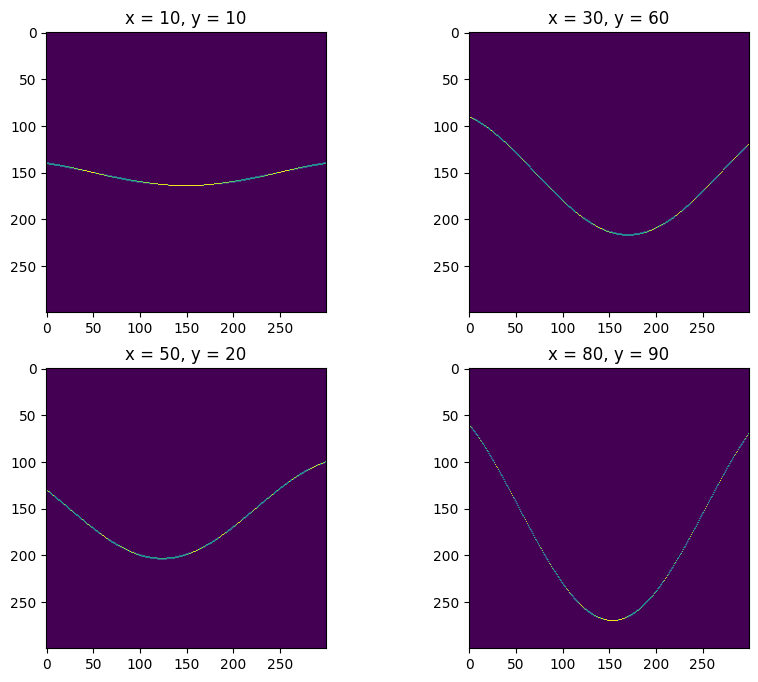

In [8]:
# (a) Create an accumulator array defined by the resolution on ρ and θ values. 
# Calculate the sinusoid that represents all the lines that pass through some nonzero point.
def compute_accumulator_array(point,size):
    accumulator=np.zeros((size,size))

    thetas = np.linspace(-np.pi / 2, np.pi , num=size)
    rhos = np.linspace(-size/2, size/2, num=size)

    for i,theta in enumerate(thetas):
        val = (point[0] * np.cos(theta)) + (point[1] * np.sin(theta)) 
        rho_bin = np.digitize(val, rhos)
        accumulator[rho_bin,i] += 1
        
    return accumulator

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(compute_accumulator_array([10,10], 300))
plt.title('x = 10, y = 10')
plt.subplot(2,2,2)
plt.imshow(compute_accumulator_array([30,60], 300))
plt.title('x = 30, y = 60')
plt.subplot(2,2,3)
plt.imshow(compute_accumulator_array([50,20], 300))
plt.title('x = 50, y = 20')
plt.subplot(2,2,4)
plt.imshow(compute_accumulator_array([80,90], 300))
plt.title('x = 80, y = 90')
plt.show()

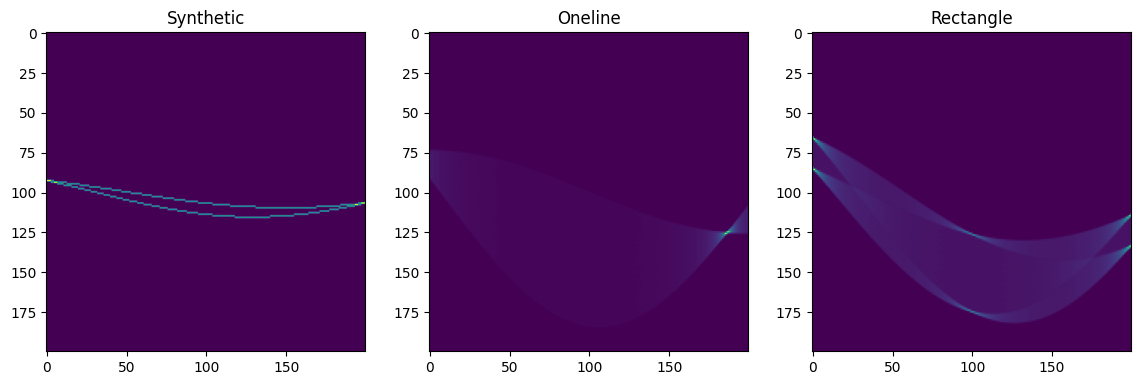

In [9]:
# (b) Implement the function hough_find_lines that accepts a binary image, 
# the number of bins for θ and ρ (allow the possibility of them being different) and a threshold.

def hough_find_lines(I, size_thetas, size_rhos, threshold):
    A = np.zeros((size_rhos, size_thetas))
    D = np.sqrt(I.shape[0]**2 + I.shape[1]**2)
    thetas = np.linspace(-np.pi/2, np.pi/2, num=size_thetas)
    rhos = np.linspace(-D, D, num=size_rhos)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i,j] != 0:
                for k, theta in enumerate(thetas):
                    val = (j * np.cos(theta)) + (i * np.sin(theta))
                    rho_bin = np.digitize(val, rhos)
                    A[rho_bin,k] += 1
    return A

synthetic_img = np.zeros((100,100))
synthetic_img[10,10] = 1
synthetic_img[10,20] = 1

synthetic_img_acc = hough_find_lines(synthetic_img, 200, 200, 0)

oneline_img = cv2.imread("images/oneline.png", cv2.IMREAD_GRAYSCALE)
rectangle_img = cv2.imread("images/rectangle.png", cv2.IMREAD_GRAYSCALE)

oneline_edges = findedges(oneline_img/255, 1, 0.16)
rectangle_edges = findedges(rectangle_img/255, 1, 0.16)

oneline_acc = hough_find_lines(oneline_edges, 200, 200, 0)
rectangle_acc = hough_find_lines(rectangle_edges, 200, 200, 0)

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.imshow(synthetic_img_acc)
plt.title('Synthetic')
plt.subplot(1,3,2)
plt.imshow(oneline_acc)
plt.title('Oneline')
plt.subplot(1,3,3)
plt.imshow(rectangle_acc)
plt.title('Rectangle')
plt.show()

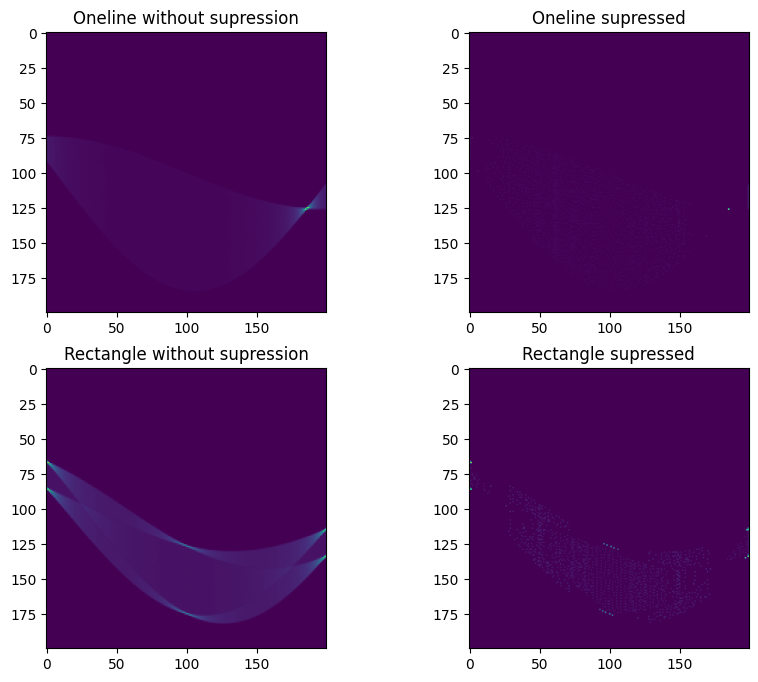

In [10]:
# (c) Implement a function named nonmaxima_suppression_box that checks the neighborhood of each pixel 
# and set it to 0 if it is not the maximum value in the neighborhood

def nonmaxima_suppression_box(A):
    supressed = A.copy()
    for i in range(1, A.shape[0]-1):
        for j in range(1, A.shape[1]-1):
            neighbors = [A[i,j+1], A[i, j-1], A[i+1, j+1],
                         A[i-1,j-1], A[i+1,j], A[i-1,j], A[i-1, j+1], A[i+1,j-1]]
            if A[i,j] < max(neighbors):
                supressed[i,j] = 0
    return supressed

oneline_supressed = nonmaxima_suppression_box(oneline_acc)
rectangle_supressed = nonmaxima_suppression_box(rectangle_acc)

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(oneline_acc)
plt.title('Oneline without supression')
plt.subplot(2,2,2)
plt.imshow(oneline_supressed)
plt.title('Oneline supressed')
plt.subplot(2,2,3)
plt.imshow(rectangle_acc)
plt.title('Rectangle without supression')
plt.subplot(2,2,4)
plt.imshow(rectangle_supressed)
plt.title('Rectangle supressed')
plt.show()

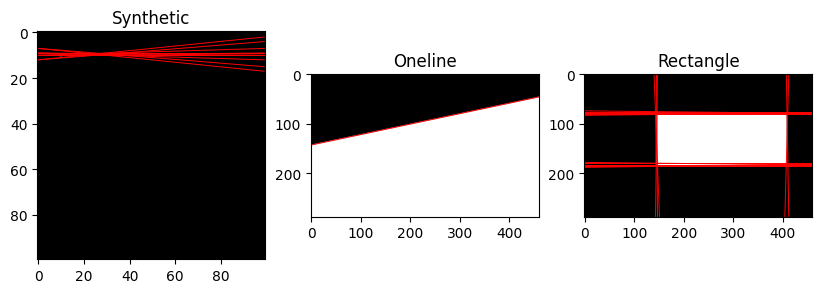

In [11]:
# (d) Search the parameter space and extract all the parameter pairs (ρ, θ) whose corresponding 
# accumulator cell value is greater than a specified threshold threshold.

def find_pairs(A, I, size_thetas, size_rhos, threshold):
    pairs = []
    D = np.sqrt(I.shape[0]**2 + I.shape[1]**2)
    thetas = np.linspace(-np.pi/2, np.pi/2, num=size_thetas)
    rhos = np.linspace(-D, D, num=size_rhos)
    for i in range(size_rhos):
        for j in range(size_thetas):
            if A[i,j] > threshold:
                pairs.append([rhos[i], thetas[j], A[i,j]])
    return pairs

img0_supressed = nonmaxima_suppression_box(synthetic_img_acc)
pairs1 = find_pairs(img0_supressed, synthetic_img, 200, 200, 1.99)

plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.imshow(synthetic_img,cmap='gray')
for pair in pairs1:
    draw_line(pair[0], pair[1], synthetic_img.shape[0], synthetic_img.shape[1])
plt.title('Synthetic')

img2_acc = hough_find_lines(oneline_edges, oneline_img.shape[0], oneline_img.shape[1], 0)
img2_supressed = nonmaxima_suppression_box(img2_acc)
pairs2 = find_pairs(img2_supressed, oneline_img, oneline_img.shape[0], oneline_img.shape[1], 800)
plt.subplot(1,3,2)
plt.imshow(oneline_img,cmap='gray')
for pair in pairs2:
    draw_line(pair[0], pair[1], oneline_img.shape[0], oneline_img.shape[1])
plt.title('Oneline')

img3_acc = hough_find_lines(rectangle_edges, rectangle_img.shape[0], rectangle_img.shape[1], 0)
img3_supressed = nonmaxima_suppression_box(img3_acc)
pairs3 = find_pairs(img3_supressed, rectangle_img, rectangle_img.shape[0], rectangle_img.shape[1], 200)
plt.subplot(1,3,3)
plt.imshow(rectangle_img,cmap='gray')
for pair in pairs3:
    draw_line(pair[0], pair[1], rectangle_img.shape[0], rectangle_img.shape[1])
plt.title('Rectangle')
plt.show()

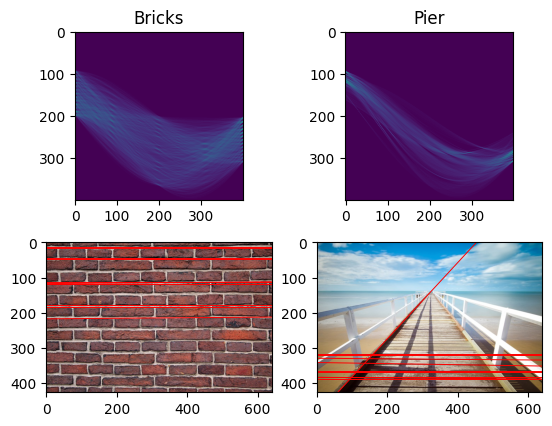

In [12]:
# (e) Read the image from files bricks.jpg and pier.jpg. Change the image to grayscale and detect edges.
# Then detect lines using your algorithm. 

bricks_img = cv2.imread("images/bricks.jpg", cv2.IMREAD_GRAYSCALE)
pier_img = cv2.imread("images/pier.jpg", cv2.IMREAD_GRAYSCALE)

bricks_edges = findedges(bricks_img/255, 1, 0.2)
pier_edges = hysteresis(pier_img/255, 1, 0.2, 0.04, 0.1)
pier_edges_2 = findedges(pier_img/255, 1, 0.2)

bricks_acc = hough_find_lines(bricks_edges, 400, 400, 0)
pier_acc = hough_find_lines(pier_edges, 400, 400, 0)
pier_acc_2 = hough_find_lines(pier_edges_2, 400, 400, 0)

bricks_supressed = nonmaxima_suppression_box(bricks_acc)
pier_supressed = nonmaxima_suppression_box(pier_acc)

bricks_pairs = find_pairs(bricks_supressed, bricks_img, 400, 400, 0)
bricks_pairs.sort(key=lambda x: x[2], reverse=True)

pier_pairs = find_pairs(pier_supressed, pier_img, 400, 400, 0)
pier_pairs.sort(key=lambda x: x[2], reverse=True)

bricks_orig = cv2.imread("images/bricks.jpg")
bricks_orig = cv2.cvtColor(bricks_orig, cv2.COLOR_BGR2RGB)
pier_orig = cv2.imread("images/pier.jpg")
pier_orig = cv2.cvtColor(pier_orig, cv2.COLOR_BGR2RGB)

plt.subplot(2,2,1)
plt.imshow(bricks_acc)
plt.title('Bricks')
plt.subplot(2,2,2)
plt.imshow(pier_acc_2)
plt.title('Pier')
plt.subplot(2,2,3)
plt.imshow(bricks_orig)
for pair in bricks_pairs[:10]:
    draw_line(pair[0], pair[1], bricks_img.shape[0], bricks_img.shape[1])
plt.subplot(2,2,4)
plt.imshow(pier_orig)
for pair in pier_pairs[:10]:
    draw_line(pair[0], pair[1], pier_img.shape[0], pier_img.shape[1])
plt.show()

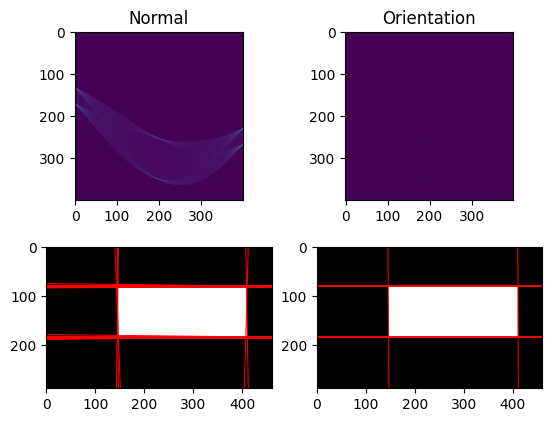

In [13]:
# (f) A problem of the Hough transform is that we need a new dimension for each additional parameter
# in the model, which makes the execution slow for more complex models. We can avoid such parameters 
# if we can reduce the parameter space, e.g. by introducing domain knowledge. 

def hough_find_lines_2(I, size_thetas, size_rhos, angles, threshold):
    A = np.zeros((size_rhos, size_thetas))
    D = np.sqrt(I.shape[0]**2 + I.shape[1]**2)
    thetas = np.linspace(-np.pi/2, np.pi/2, num=size_thetas)
    rhos = np.linspace(-D, D, num=size_rhos)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i,j] != 0:
                angle = angles[i,j]
                angle = np.mod(angle + np.pi / 2, np.pi) - np.pi / 2
                # theta_index = np.digitize(angle, thetas)
                theta_index = np.argmin(np.abs(thetas - angle))
                val = (j * np.cos(angle)) + (i * np.sin(angle))
                rho_bin = np.digitize(val, rhos)
                A[rho_bin, theta_index] += 1
    return A

M, angles = gradient_magnitude(rectangle_img/255, 1)
rectangle_acc_modified = hough_find_lines_2(rectangle_edges, 400, 400, angles, 0)
rectangle_acc_normal = hough_find_lines(rectangle_edges, 400, 400, 0)

normal_acc = hough_find_lines(rectangle_edges, rectangle_img.shape[0], rectangle_img.shape[1], 0)
normal_supressed = nonmaxima_suppression_box(normal_acc)
pairs_normal = find_pairs(normal_supressed, rectangle_img, rectangle_img.shape[0], rectangle_img.shape[1], 200)

modified_acc = hough_find_lines_2(rectangle_edges, rectangle_img.shape[0], rectangle_img.shape[1], angles, 0)
modified_supressed = nonmaxima_suppression_box(modified_acc)
pairs_modified = find_pairs(modified_supressed, rectangle_img, rectangle_img.shape[0], rectangle_img.shape[1], 50)

plt.subplot(2,2,1)
plt.imshow(rectangle_acc_normal)
plt.title('Normal')
plt.subplot(2,2,2)
plt.imshow(rectangle_acc_modified)
plt.title('Orientation')
plt.subplot(2,2,3)
plt.imshow(rectangle_img,cmap='gray')
for pair in pairs_normal:
    draw_line(pair[0], pair[1], rectangle_img.shape[0], rectangle_img.shape[1])
plt.subplot(2,2,4)
plt.imshow(rectangle_img,cmap='gray')
for pair in pairs_modified:
    draw_line(pair[0], pair[1], rectangle_img.shape[0], rectangle_img.shape[1])
plt.show()

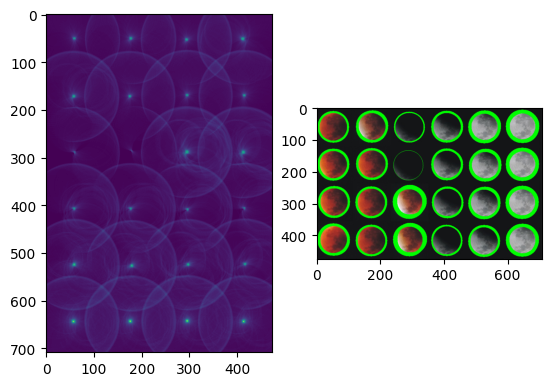

In [14]:
# (g) Implement a Hough transform that detects circles of a fixed radius. 
# You can test the algorithm on image eclipse.jpg. Try using a radius somewhere between 45 and 50 pixels.

def find_circles(I, height, width, radius):
    A = np.zeros((height, width))
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i,j] != 0:
                for theta in range(0, 360):
                        a = int(j - radius * np.cos(np.radians(theta)))
                        b = int(i + radius * np.sin(np.radians(theta)))

                        if 0 <= a < width and 0 <= b < height:
                            A[b, a] += 1
    return A

eclipse_img_gray = cv2.imread("images/eclipse.jpg", cv2.IMREAD_GRAYSCALE)
eclipse_img = cv2.imread("images/eclipse.jpg")
eclipse_img = cv2.cvtColor(eclipse_img, cv2.COLOR_BGR2RGB)

eclipse_edge = findedges(eclipse_img_gray / 255, 1, 0.05)

eclipse_img_acc = find_circles(eclipse_edge, eclipse_img_gray.shape[0], eclipse_img_gray.shape[1], 47)

centers = np.where(eclipse_img_acc >= 85)

# Draw circles on the original image
result_image = eclipse_img.copy()
for center_y, center_x in zip(centers[0], centers[1]):
    cv2.circle(result_image, (center_x, center_y), 47, (0, 255, 0), 1)

plt.subplot(1,2,1)
plt.imshow(eclipse_img_acc.T)
plt.subplot(1,2,2)
plt.imshow(result_image)
plt.show()

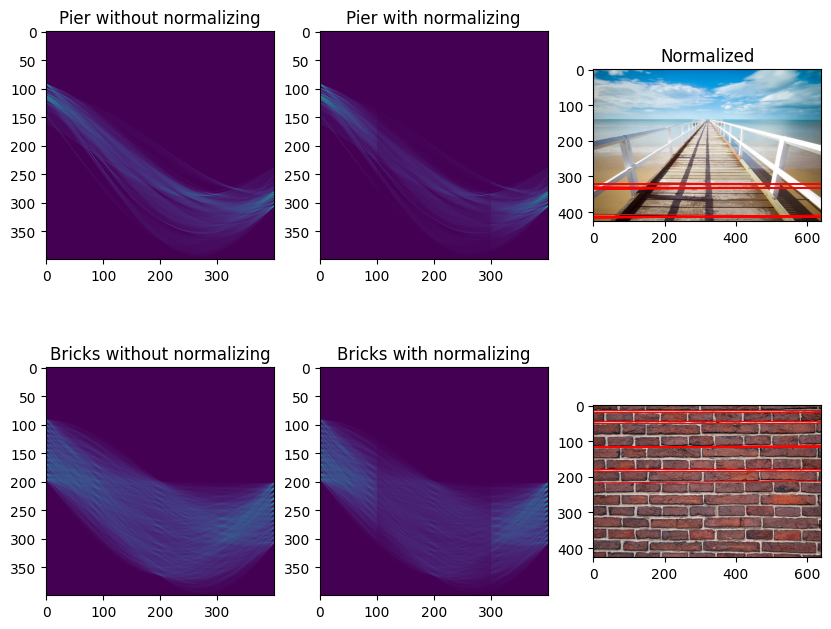

In [15]:
# (h) Extend your algorithm so that it normalizes the number of votes according to
# the maximum number of votes possible for a given line

def hough_find_lines_normalised(I, size_thetas, size_rhos, threshold):
    A = np.zeros((size_rhos, size_thetas))
    D = np.sqrt(I.shape[0]**2 + I.shape[1]**2)
    thetas = np.linspace(-np.pi/2, np.pi/2, num=size_thetas)
    rhos = np.linspace(-D, D, num=size_rhos)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i,j] != 0:
                for k, theta in enumerate(thetas):
                    val = (j * np.cos(theta)) + (i * np.sin(theta))
                    rho_bin = np.digitize(val, rhos)
                    A[rho_bin,k] += 1

    max_votes_per_line = np.zeros_like(A)
    for k in range(size_thetas):
        for rho_bin in range(size_rhos):
            theta = thetas[k]
            # If the absolute value of the sine of the angle (sin(theta)) is greater than the absolute value of the cosine of the angle
            #  (cos(theta)), it implies a more vertical line. In this case, the line length is calculated as the height of the image 
            # (I.shape[0]) divided by the absolute value of the sine of the angle.
            if np.abs(np.sin(theta)) > np.abs(np.cos(theta)):
                line_length = I.shape[0] / np.abs(np.sin(theta))
            # If the absolute value of the cosine of the angle is greater, it implies a more horizontal line.
            # In this case, the line length is calculated as the width of the image (I.shape[1]) divided by 
            # the absolute value of the cosine of the angle.
            else:
                line_length = I.shape[1] / np.abs(np.cos(theta))

            max_votes_per_line[rho_bin, k] = line_length

    max_votes_per_line[max_votes_per_line == 0] = 1

    A_normalized = A / max_votes_per_line

    A_normalized[A_normalized < threshold] = 0
    return A_normalized

bricks_normal = hough_find_lines(bricks_edges, 400, 400, 0)
bricks_normalized = hough_find_lines_normalised(bricks_edges, 400,400, 0)

pier_normal = hough_find_lines(pier_edges_2, 400, 400, 0)
pier_normalized = hough_find_lines_normalised(pier_edges_2, 400,400, 0)


bricks_normal_supressed = nonmaxima_suppression_box(bricks_normal)
pier_normal_supressed = nonmaxima_suppression_box(pier_normal)

bricks_normal_pairs = find_pairs(bricks_normal_supressed, bricks_img, 400, 400, 0)
bricks_normal_pairs.sort(key=lambda x: x[2], reverse=True)

pier_normal_pairs = find_pairs(pier_normal_supressed, pier_img, 400, 400, 0)
pier_normal_pairs.sort(key=lambda x: x[2], reverse=True)

bricks_normalized_supressed = nonmaxima_suppression_box(bricks_normalized)
pier_normalized_supressed = nonmaxima_suppression_box(pier_normalized)

bricks_normalized_pairs = find_pairs(bricks_normalized_supressed, bricks_img, 400, 400, 0)
bricks_normalized_pairs.sort(key=lambda x: x[2], reverse=True)

pier_normalized_pairs = find_pairs(pier_normalized_supressed, pier_img, 400, 400, 0)
pier_normalized_pairs.sort(key=lambda x: x[2], reverse=True)

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.imshow(pier_normal)
plt.title('Pier without normalizing')
plt.subplot(2,3,2)
plt.imshow(pier_normalized)
plt.title('Pier with normalizing')
plt.subplot(2,3,3)
plt.imshow(pier_orig)
for pair in pier_normalized_pairs[:10]:
    draw_line(pair[0], pair[1], pier_img.shape[0], pier_img.shape[1])
plt.title("Normalized")
plt.subplot(2,3,4)
plt.imshow(bricks_normal)
plt.title('Bricks without normalizing')
plt.subplot(2,3,5)
plt.imshow(bricks_normalized)
plt.title('Bricks with normalizing')
plt.subplot(2,3,6)
plt.imshow(bricks_orig)
for pair in bricks_normalized_pairs[:10]:
        draw_line(pair[0], pair[1], bricks_img.shape[0], bricks_img.shape[1])
plt.show()